In [1]:
#Library imports for torch

import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(10)

In [2]:
#Gaussian Noise Transformation and DataLoader implementation 

import random

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.25
    
    if torch.rand(1) < 0.5:
        return img
    
    out = img + sigma * torch.randn_like(img)
    
    out = out.clamp(0, 1)
        
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out


transform = transforms.Compose(
    [transforms.ToTensor(),
     gauss_noise_tensor,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

noisy_trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
noisy_trainloader = torch.utils.data.DataLoader(noisy_trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)


classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


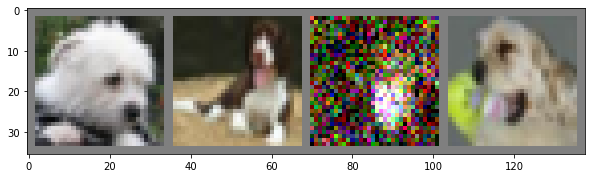

dog   dog   frog  dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.figure(figsize=(10,20))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
dataiter = iter(noisy_trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [4]:
# CNN network implementation

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# CNN training 

import torch.optim as optim
import time
import math

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

training_log = []

start_time = time.time()

for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(noisy_trainloader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss:{running_loss / 2000:.3f}")
            training_log.append([math.ceil(time.time() - start_time), running_loss/2000])
            running_loss = 0.0
    
print("Finished Training")

file = open("cnn_noisy.log", "w")
file.write("time, loss\n")

for line in training_log:
    file.write("\n")
    file.write(",".join([str(x) for x in line]))
    file.write("\n")

[1,  2000] loss:2.150
[1,  4000] loss:1.821
[1,  6000] loss:1.662
[1,  8000] loss:1.600
[1, 10000] loss:1.528
[1, 12000] loss:1.532
[2,  2000] loss:1.460
[2,  4000] loss:1.467
[2,  6000] loss:1.415
[2,  8000] loss:1.411
[2, 10000] loss:1.412
[2, 12000] loss:1.386
Finished Training


              precision    recall  f1-score   support

       plane       0.60      0.59      0.59      1015
         car       0.59      0.67      0.63       878
        bird       0.38      0.37      0.37      1044
         cat       0.05      0.41      0.09       129
        deer       0.28      0.46      0.34       606
         dog       0.50      0.40      0.45      1252
        frog       0.80      0.39      0.52      2050
       horse       0.57      0.58      0.57       986
        ship       0.69      0.58      0.63      1193
       truck       0.51      0.60      0.55       847

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.58      0.50      0.52     10000



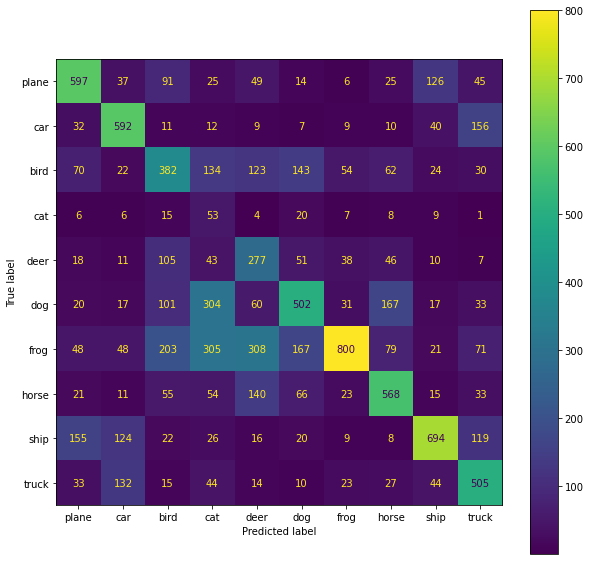

In [6]:
# CNN model testing 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import matplotlib.pyplot as plt


total = 0
correct = 0

predictions = []
actuals = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
     
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        actuals.extend(labels)
        predictions.extend(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
cf_matrix = confusion_matrix(predictions, actuals)

cd = ConfusionMatrixDisplay(cf_matrix, display_labels=classes)

fig, ax = plt.subplots(figsize=(10,10))
cd.plot(ax=ax)

fig.savefig("images/cnn_noisy.png")        
    
print(classification_report(predictions, actuals, target_names=classes))